# MD full code


## Main program
**Date:** `27-01-2025`

Total no of particles =  216
radius = 0.5
particle in a roh = 6
distance b/w two particles = 1.0696951581076473
length of the box = 6.348475790538236
Position initialized!!
Temperature =  1.0
Velocity initialized!!
Final position and velocity stored succesfully
DONE!!!  Value are stored in the file
CPU Time(s) =  1592.4375
Position ploted 


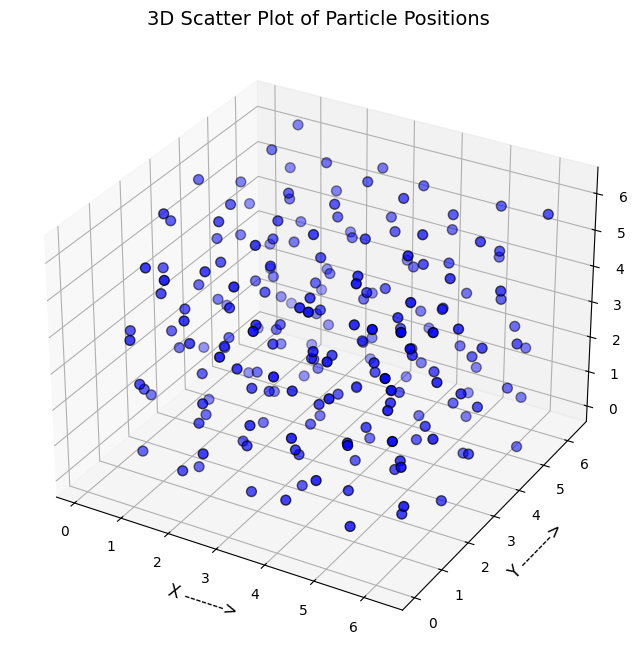

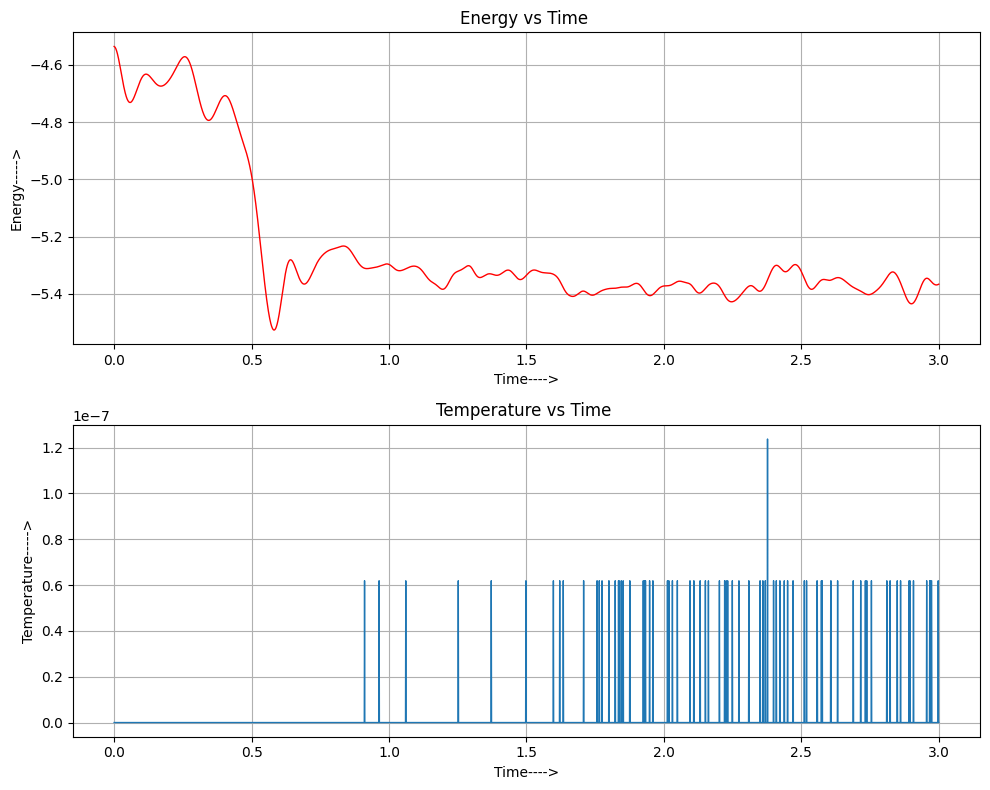

In [18]:
# Full MD code
#################### ALL THE FUNCTIONS USED IN THIS CELL ARE WRITTEN BELOW. PLS RUN THOSE CELL FIRST ################## 
import time
import sys
import numpy as np
import matplotlib.pyplot as plt

cpu_start = time.process_time()
N=216     # Total no. of particles.(cube root must be integer)
m=1
sig=1
roh=0.8442
rc = 2.5    # cutoff lenth
box_length = 6.348475790538236 # for roh = 0.8442

# call the function for posn init
x,y,z=posn_initialize(N,sig,roh)
print('Position initialized!!')

# call the function for velocity init
vx,vy,vz=velocity_initialize(N)
print('Velocity initialized!!')

V=np.column_stack((vx, vy, vz))
X=np.column_stack((x, y, z))


# Parameters for ain loop                  <-------------------------------------------
t = 0.0
dt = 0.001
tmax = 1.0
coords_old = X - V * dt

#Array for store and ploting the energy and temp
tarray = []
Earray = []
Temparray = []
#Main loop of the simulation                  <-------------------------------------------
Etot = 0.0
Temp = 0.0
with open("sample.txt", "w") as file:
    file.write(f"{t:.8f} \t {Etot:.8f} \t {Temp:.8f}\n")
    
with open("Trajectory.xyz", "w") as f:
    pass
count=0
while (t < tmax):
    F, total_pot = forces(X)
    X, Etot, Temp,coords_old,V = integrate(F, X, total_pot,sig, box_length, N, coords_old)
    X = PBC(X,box_length)
    # Energy and Temp stpre for ploting 
    tarray.append(t)
    Earray.append(Etot)
    Temparray.append(Temp)
    with open("sample.txt", "a") as file:
        file.write(f"{t:.8f} \t {Etot:.8f} \t {Temp:.8e}\n")
    t = t + dt
    if (np.mod(count,10) == 0):
        sample_trajectory(X)
    count=count+1


#Updated posn and velocity store in file
final_posn_velo_store(X,V)
# Final position store .xyz file
with open("final_posn.xyz", "w") as f:
        f.write('216\n')
        f.write(f"Ar \t X \t\t Y \t\t Z \t\t \n")
for i in range(N):
    with open("final_posn.xyz", "a") as f:
        f.write(f"Ar \t {X[i,0]:.8f}\t{X[i,1]:.8f}\t{X[i,2]:.8f} \n")
print('DONE!!!  Value are stored in the file')
cpu_end = time.process_time()
print("CPU Time(s) = ", cpu_end - cpu_start)
plotX(X)

#ploting
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1) 
plt.title("Energy vs Time ")
plt.xlabel("Time---->")
plt.ylabel("Energy----->")
plt.grid()
plt.plot(tarray, Earray, 'r', linewidth=1, label=" ")


plt.subplot(2, 1, 2)  
plt.title("Temperature vs Time ")
plt.xlabel("Time---->")
plt.ylabel("Temperature----->")
plt.grid()
plt.plot(tarray, Temparray, linewidth=1, label=" ")

plt.tight_layout()
plt.show()


# Functions

## Position initialize

In [2]:
def posn_initialize(N,sig,roh):
    """
    N: otal no of particles
    sig: diameter
    roh: number density
    This is a function to initialize the positions of the particles in a box, simple qubic(not fcc or bccc).
    Getting box size from N and roh.
    
    """
    n=round(N**(1/3))  # Particles in a line.
    r=sig/2
    x=np.zeros(N)
    y=np.zeros(N)
    z=np.zeros(N)
    volume = N/roh
    l = (volume)**(1/3)  # length of the square box
    dx=(l-sig)/(n-1)
    
    #initialization
    x[0] = y[0] = z[0] = r

    print('Total no of particles = ',N)
    print('radius =',r)
    print('particle in a roh =',n)
    print('distance b/w two particles =',dx)
    print('length of the box =',l)

    with open("initial_posn.xyz", "w") as f:
        f.write('216\n')
        f.write(f"Ar \t X \t\t Y \t\t Z \t\t \n")
    with open("initial_posn.xyz", "a") as f:
        f.write(f"Ar \t {x[0]:.8f}\t{y[0]:.8f}\t{z[0]:.8f} \n")
    
    z_count = 0
    for i in range(1,N):
        # z increasing but y and x reamin same until {read next comment}
        z[i] = z[i-1]+dx
        y[i] = y[i-1]
        x[i] = x[i-1]
        # hit max no of particles in a roh, then z get initial val and increase y (triggering y)
        if (np.mod(i,n)) == 0:
            z[i] = r
            y[i] += dx 
            z_count += 1
            # doing same as previous condition.(tiggering x)
            if ((np.mod(z_count,n)) == 0):
                y[i] = r
                x[i] += dx
        with open("initial_posn.xyz", "a") as f:
            f.write(f"Ar \t {x[i]:.8f}\t{y[i]:.8f}\t{z[i]:.8f} \n")

    return x,y,z
        

## Velocity initialize

In [3]:
import numpy as np
N = 216   # Number of particles
def velocity_initialize(N):
    """Initialize velocities of N particles from a normal distribution, 
    remove net momentum, and normalize."""
    # T is given temprature
    mean, k_B, T = 0, 1.0, 1.0
    std_dev = k_B * T
    bins = int(np.sqrt(N))

    # Generate velocities and remove net momentum
    velocities = np.random.normal(mean, std_dev, (N, 3))
    velocities -= velocities.mean(axis=0)

    # Normalize to match desired temperature
    temperature = 0.5 * np.sum(velocities**2)
    velocities *= np.sqrt(T/temperature)

    temperature = 0.5 * np.sum(velocities**2)
    print('Temperature = ', temperature)
    vx = velocities[:, 0]
    new_std = np.std(vx)
    # Save to file
    np.savetxt("initial_velo.txt", velocities, fmt="%.8f", delimiter="\t")

    '''   
    # Uncomment below for plotting distribution of velocity
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(["$V_x$", "$V_y$", "$V_z$", "Speed"]):
        plt.subplot(2, 2, i + 1)
        data = velocities[:, i] if i < 3 else np.linalg.norm(velocities, axis=1)
        plt.hist(data, bins=bins, density=True, alpha=0.9, color='b')
        plt.title(f"Histogram of {label} Distribution")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        if (i < 3):
            x1 = np.linspace(mean - 0.25*std_dev, mean + 0.25*std_dev, 500)
            pdf = (1 / (new_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x1 - mean) / new_std)**2)
            plt.plot(x1, pdf, 'r', linewidth=2, label="Normal Distribution ")
        else:
            x1 = np.linspace(0, 0.25, 500)
            a = 23000.0
            b = 330
            pdf = a * np.pi * x1**2 * (m / (2 * np.pi * k_B * temperature))**1.5 * np.exp(-m*b * x1**2 / (2 * k_B * temperature))
            plt.plot(x1, pdf, 'r', linewidth=2, label="MB Distribution")
        plt.grid()
        plt.legend()
    plt.tight_layout()
    plt.show()
    '''
    return velocities[:, 0], velocities[:, 1], velocities[:, 2]
    

## periodic boundary condition and minimum image convention

In [19]:
import math
def PBC(coord,box_length):
    """
    PBC is applied in this function.
    coord: 2D array of size (particle no. , 3)
    box_lenth: lenth of one side of cubic box
    """

    # 
    for i in range(N): 
        for j in range(3):
            if (coord[i, j] > box_length):
                coord[i, j] -= box_length* math.floor(coord[i, j]/box_length)
            elif (coord[i, j] < 0.0):
                coord[i, j] += box_length* math.ceil(coord[i, j]/box_length)
            
            # if (coord[i, j] > box_length and coord[i, j] < 2*box_length):
            #     coord[i, j] -= box_length
            # elif (coord[i, j] < 0.0 and coord[i, j] > -box_length):
            #     coord[i, j] += box_length
            # # For extra sefty , exit if any particles goes outside the box 
            # elif coord[i, j] > 2*box_length:
            #     print('Too right shift',i,j)
            #     sys.exit()
            # elif coord[i, j] < -box_length:
            #     print('Too left shift',i,j,coord[i, j])
            #     sys.exit()
                
    return coord

def min_img_conv(coordinate1, coordinate2, box_length):
    displacement = coordinate2 - coordinate1
    displacement -= np.round(displacement / box_length) * box_length
    return displacement



## Force calculation

In [5]:
def forces(coordinates):
    """
    This function is for calculate total force on each particles and total potential energy.
    Input: coordinates(particle no. , 3)
    Output: Force(Particle no.) and Total pot
    """
    #print('r cutoff  =  ', rc)
    rc2 = rc**2
    npart=N
    F=np.zeros([npart,3])
    total_pot = 0.0
    r2c = 1/rc2
    r6c = r2c**3
    pot_cut = 4.0*r6c*(r6c-1)
    ''' 
    with open("force.txt", "w") as f:
        f.write(f"fx \t \t fy \t \t fz \n")
    '''  
    for i in range(npart-1):
        for j in range(i+1,npart):
            dx,dy,dz = min_img_conv(coordinates[j,:], coordinates[i,:], box_length)
            r2 = dx**2+dy**2+dz**2
            if (r2 < rc2) :
                r2i = 1/r2
                r6i = r2i**3
                ff = 48.0*r2i*r6i*(r6i - 0.5)
                F[i,0] = F[i,0] + ff*dx
                F[j,0] = F[j,0] - ff*dx
                F[i,1] = F[i,1] + ff*dy
                F[j,1] = F[j,1] - ff*dy
                F[i,2] = F[i,2] + ff*dz
                F[j,2] = F[j,2] - ff*dz
                total_pot = total_pot + 4.0*r6i*(r6i-1)- pot_cut
    '''  
    for i in range(npart):
        with open("force.txt", "a") as f:
            f.write(f"{F[i,0]:.8f}\t{F[i,1]:.8f}\t{F[i,2]:.8f} \n")
    '''
    return F, total_pot
            

## Integratrion

In [11]:

def integrate(force, coords,totpot,sig, box_length, N, coords_old):
    # Verlet algorthm
    coords_new = 2*coords - coords_old + dt**2 * force
    threshold = sig/10
    # Initialize overlap detection flag
    overlap_detected = False
    for i in range(N-1):
        for j in range(i+1, N):
            dx,dy,dz = min_img_conv(coords_new[i,:], coords_new[j,:], box_length)
            dr = np.sqrt(dx**2 + dy**2 +dz**2)
            if dr < threshold:
                print(f"Warning: Particles {i} and {j} overlap! at time = {t}")
                print("Overlapping detected, stopping the simulation.")
                overlap_detected = True
                break
        if overlap_detected:
            sys.exit()
            break
    vi = (coords_old - coords_new)/2*dt
    vi -= vi.mean(axis=0)
    vi2tot = sum(vi**2)
    
    etot = (totpot + 0.5*sum(vi2tot))/N
    temp = sum(vi2tot)/(3*N)
    coords_old = coords
    coords = coords_new
    return coords_new, etot, temp,coords_old, vi
    

## Sampling

In [15]:
def sample_trajectory(X): 
    with open("Trajectory.xyz", "a") as f:
            f.write('216\n')
            f.write(f"Ar \t X \t\t Y \t\t Z \t\t \n")
    for i in range(N):
        with open("Trajectory.xyz", "a") as f:
            f.write(f"Ar \t {X[i,0]:.8f}\t{X[i,1]:.8f}\t{X[i,2]:.8f} \n")
    return 0

## Position plot (Optional)

In [8]:

def plotX(X):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    N = len(X[:,0])  # Number of particles
    print('Position ploted ')
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set the title and labels
    ax.set_title('3D Scatter Plot of Particle Positions', fontsize=14)
    ax.set_xlabel('X ------->', fontsize=12)
    ax.set_ylabel('Y ------->', fontsize=12)
    ax.set_zlabel('Z ------->', fontsize=12)
    
    # Plot the data
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=50, c='blue', edgecolors='black')
    
    # Show the plot
    plt.show()
    return 0


## Final position and velocity store

In [9]:
def final_posn_velo_store(X,V):
    with open("updated_coords.txt", "w") as f:
        for i in range(N):
            f.write(f" {X[i,0]:.8f}\t{X[i,1]:.8f}\t{X[i,2]:.8f} \n")
    with open("updated_velocities.txt", "w") as f:
        for i in range(N):
            f.write(f" {V[i,0]:.8f}\t{V[i,1]:.8f}\t{V[i,2]:.8f} \n")
    print('Final position and velocity stored succesfully')
    return 0